writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ..\..\..\..\..\Environment\mf6.4.2_win64\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jun 28 2023 18:41:13 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although 

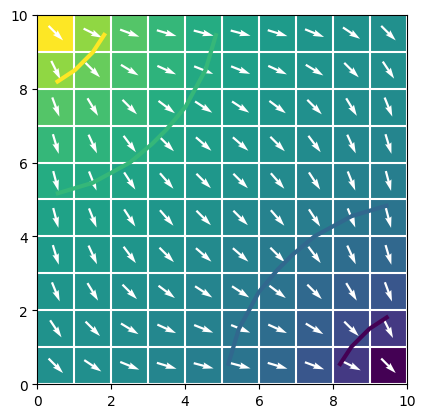

In [4]:
import os
import flopy
ws = './mymodel'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(gwf, nrow=10, ncol=10)
ic = flopy.mf6.ModflowGwfic(gwf)
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True)
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, 0), 1.],
                                                       [(0, 9, 9), 0.]])
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
sim.write_simulation()
sim.run_simulation()

head = gwf.output.head().get_data()
bud = gwf.output.budget()

spdis = bud.get_data(text='DATA-SPDIS')[0]
pmv = flopy.plot.PlotMapView(gwf)
pmv.plot_array(head)
pmv.plot_grid(colors='white')
pmv.contour_array(head, levels=[.2, .4, .6, .8], linewidths=3.)
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
pmv.plot_vector(qx, qy, normalize=True, color="white")

In [5]:
import numpy as np
import pandas as pd
import flopy
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
%config InlineBackend.figure_format = 'svg'
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
config = {
    'font.family':'Times New Roman',
    'font.size': 15,
    'font.serif': ['SimSun'],
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'mathtext.fontset':'stix',
    'savefig.dpi':300,}
plt.rcParams.update(config)

c:\Environment\MiniConda\envs\mainPy\lib\site-packages\matplotlib_inline\config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [6]:
modelname = "my_model" # 模型名称
mf = flopy.modflow.Modflow(modelname, exe_name="mf2005", namefile_ext = 'nam', model_ws = './mymodel', version = 'mf2005')
# 网格信息
Lx = 200.0                   # x的长度
Ly = 100.0                   # y的长度
ztop = 0.0                   # z的顶部高程
zbot = -10.0                 # z的底部高程
nlay = 1                     # 含水层数量
nrow = 10                    # x网格数
ncol = 20                    # y网格数
delr = Lx / nrow             # x步长
delc = Ly / ncol             # y步长
delv = (ztop - zbot) / nlay  # z步长
botm = np.linspace(ztop, zbot, nlay + 1)

# Discretization Input File (DIS) 离散化输入文件，参数分别是 模型名，层数，x格数，y格数，x，y密度，顶部高程，底部高程
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr = delr, delc = delc, 
                               top = ztop, 
                               botm = botm[1:]) # botm[0]为top的值，因此从1开始计数)

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
ibound[:,-1,10:16] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = 1.0
strt[:, 0:9, -1] = 4.0
strt[:, -1, 10:16] = 3.0
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

hk = np.ones((nlay, nrow, ncol), dtype=np.float32)
hk[:,:,0:5] = 10.0
hk[:,0:2,5:10] = 1.0
hk[:,2:7,5:10] = 5.0
hk[:,7:10,5:10] = 2.0
hk[:,:,10:20] = 8.0
lpf = flopy.modflow.ModflowLpf(mf, hk = hk, vka = 10.0, ipakcb=53)
# laytyp (int or array of ints (nlay)) 默认为0，表明为承压含水层
# 0 confined >0 convertible <0 convertible unless the THICKSTRT option is in effect. (default is 0).

spd = {0: [[0, 8, 18, -500], [0, 4, 4, 400], [0, 5, 10, -300], [0, 1, 15, 600]]}
wel = flopy.modflow.ModflowWel(mf, stress_period_data = spd)

spd = {(0, 0): ["print head", "print budget", "save head", "save budget"]}
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)
pcg = flopy.modflow.ModflowPcg(mf)

mf.write_input()
success, buff = mf.run_model()
if not success:
    raise Exception("MODFLOW did not terminate normally.")

FloPy is using the following executable to run the model: ..\..\..\..\..\Environment\MF2005.1_12\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: my_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/10/04 16:14:58

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/10/04 16:14:58
 Elapsed run time:  0.050 Seconds

  Normal termination of simulation


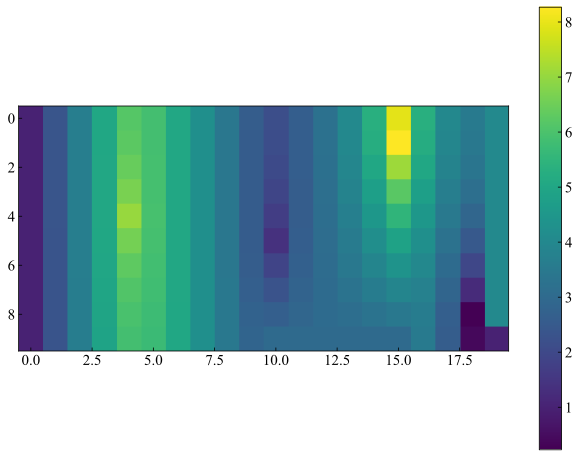

In [7]:
# 提取水头数据
hds = bf.HeadFile('./mymodel/my_model' + ".hds")
head = hds.get_data(totim=1.0)
df = pd.DataFrame(head[0])
plt.figure(figsize=(11,8))
plt.imshow(df)
plt.colorbar()